# DeepLDA: Alanine dipeptide and aldol reaction

Reference paper: _Bonati, Rizzi and Parrinello, [JCPL](https://pubs.acs.org/doi/10.1021/acs.jpclett.0c00535) (2020)_ [[arXiv]](https://arxiv.org/abs/2002.06562).

Prerequisite: DeepLDA tutorial.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/examples/ex_DeepLDA.ipynb)

## Setup

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""

In [2]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh EXAMPLE', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(42)

/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Alanine dipeptide

We first train a DeepLDA CV on the alanine dipeptide data, which is one of the examples of the [DeepLDA paper](https://pubs.acs.org/doi/10.1021/acs.jpclett.0c00535). This is a small molecule often used as a benchmark for enhanced sampling, as it has two metastable states which are well described by the Ramachandran angles $\phi$ and $\psi$. To build a general mode, we will not use this information and just use as input features the 45 distances between heavy atoms.

<center><img src="images/alanine.png" width="500" /></center>

### Load data

We use the alanine dipeptide simulation data from the [PLUMED-MASTERCLASS](https://github.com/luigibonati/masterclass-plumed/) repository.

In [3]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

filenames = [ "https://raw.githubusercontent.com/luigibonati/masterclass-plumed/main/1_DeepLDA/0_unbiased-sA/COLVAR", 
              "https://raw.githubusercontent.com/luigibonati/masterclass-plumed/main/1_DeepLDA/0_unbiased-sB/COLVAR" ]

n_states = len(filenames)

# load dataset
dataset, df = create_dataset_from_files(filenames,
                                        filter_args={'regex':'d_' }, # select distances between heavy atoms
                                        create_labels=True,
                                        return_dataframe=True, 
                                        )

datamodule = DictModule(dataset,lengths=[0.8,0.2])

Class 0 dataframe shape:  (5001, 53)
Class 1 dataframe shape:  (5001, 53)

 - Loaded dataframe (10002, 53): ['time', 'phi', 'psi', 'theta', 'xi', 'ene', 'd_2_5', 'd_2_6', 'd_2_7', 'd_2_9', 'd_2_11', 'd_2_15', 'd_2_16', 'd_2_17', 'd_2_19', 'd_5_6', 'd_5_7', 'd_5_9', 'd_5_11', 'd_5_15', 'd_5_16', 'd_5_17', 'd_5_19', 'd_6_7', 'd_6_9', 'd_6_11', 'd_6_15', 'd_6_16', 'd_6_17', 'd_6_19', 'd_7_9', 'd_7_11', 'd_7_15', 'd_7_16', 'd_7_17', 'd_7_19', 'd_9_11', 'd_9_15', 'd_9_16', 'd_9_17', 'd_9_19', 'd_11_15', 'd_11_16', 'd_11_17', 'd_11_19', 'd_15_16', 'd_15_17', 'd_15_19', 'd_16_17', 'd_16_19', 'd_17_19', 'walker', 'labels']
 - Descriptors (10002, 45): ['d_2_5', 'd_2_6', 'd_2_7', 'd_2_9', 'd_2_11', 'd_2_15', 'd_2_16', 'd_2_17', 'd_2_19', 'd_5_6', 'd_5_7', 'd_5_9', 'd_5_11', 'd_5_15', 'd_5_16', 'd_5_17', 'd_5_19', 'd_6_7', 'd_6_9', 'd_6_11', 'd_6_15', 'd_6_16', 'd_6_17', 'd_6_19', 'd_7_9', 'd_7_11', 'd_7_15', 'd_7_16', 'd_7_17', 'd_7_19', 'd_9_11', 'd_9_15', 'd_9_16', 'd_9_17', 'd_9_19', 'd_11_15

We can inspect the distances through their histograms, from which we notice that no one is able to discriminate between the states.

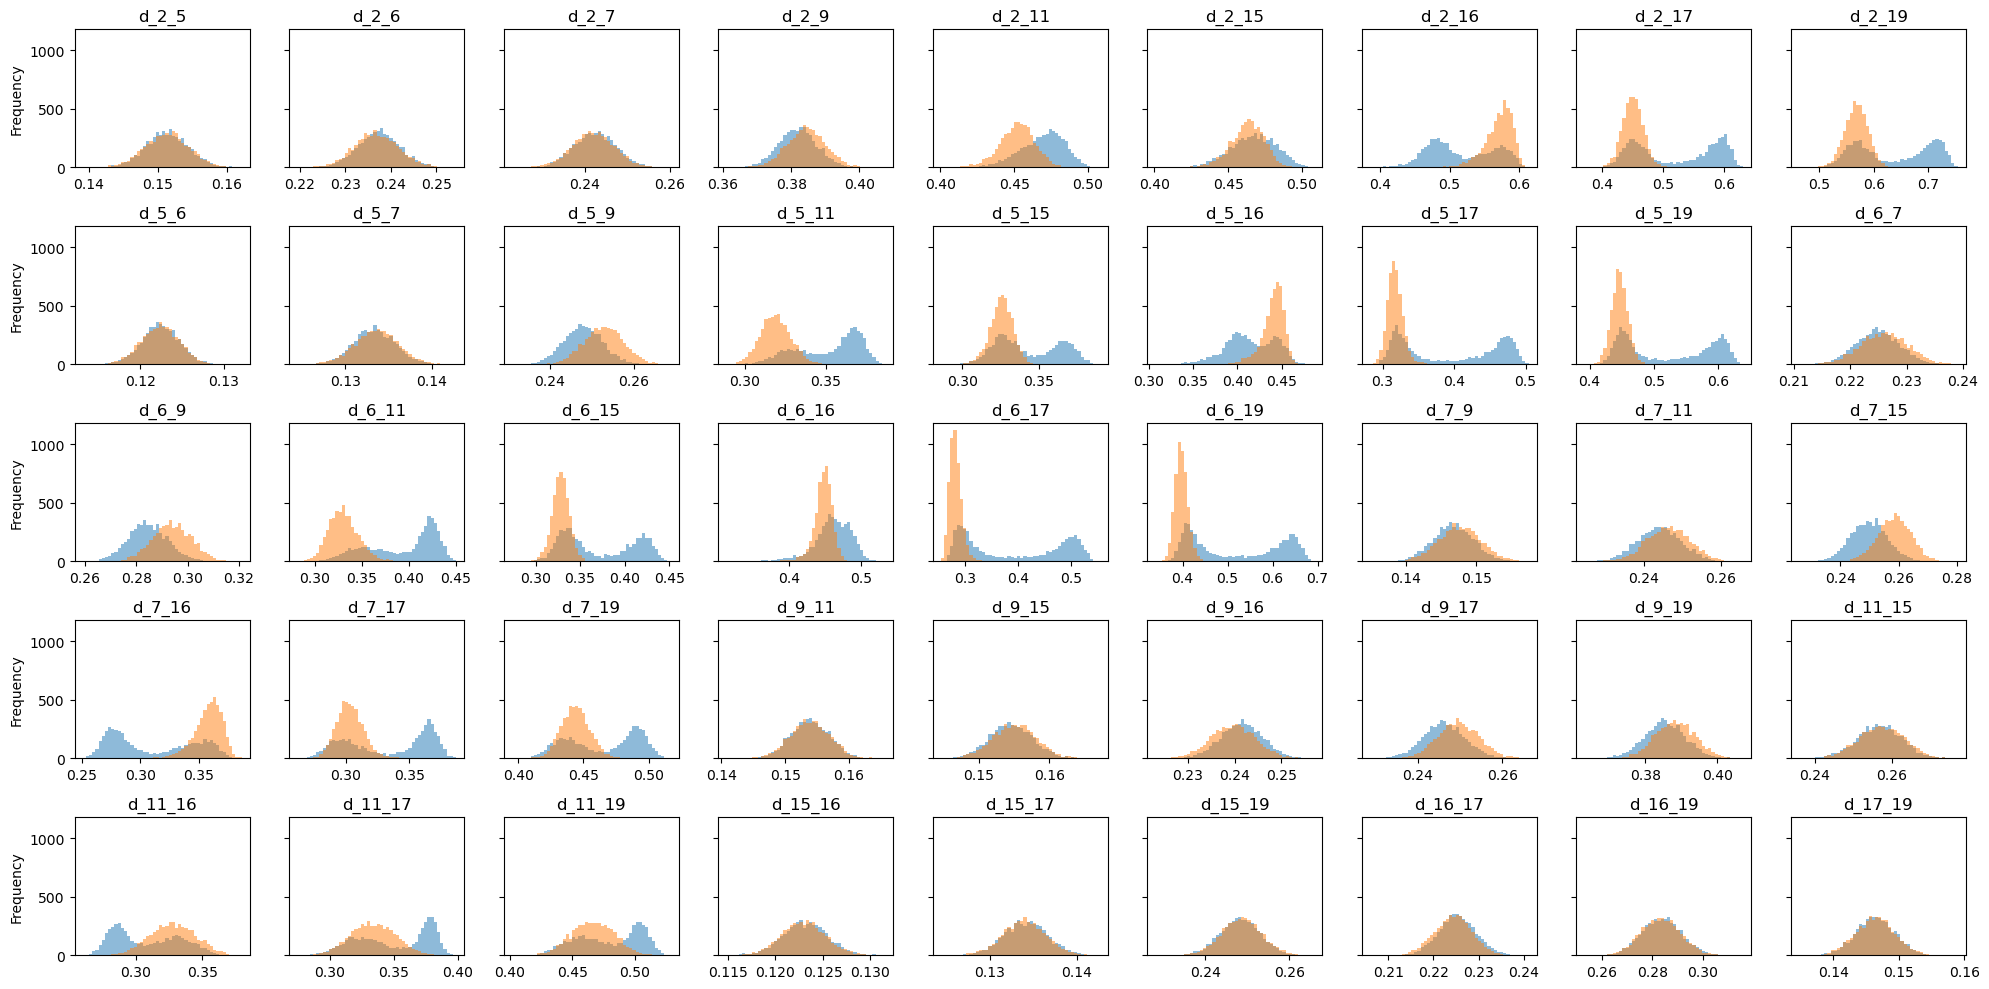

In [4]:
descriptors_names = df.filter(regex='d_').columns.values

fig,axs = plt.subplots(5,9,figsize=(20,10),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    df.pivot(columns='labels')[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False)
    ax.set_title(desc)

plt.tight_layout()

### Train DeepLDA 

Define CV

In [5]:
from mlcolvar.cvs import DeepLDA

n_input           = dataset['data'].shape[-1]
nodes             = [n_input,30,30,2]
# MODEL
model = DeepLDA(nodes, n_states=n_states)

model

DeepLDA(
  (loss_fn): ReduceEigenvaluesLoss()
  (norm_in): Normalization(in_features=45, out_features=45, mode=mean_std)
  (nn): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=45, out_features=30, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=30, out_features=30, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=30, out_features=2, bias=True)
    )
  )
  (lda): LDA(in_features=2, out_features=1)
)

Define trainer and fit

In [6]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=0.1, patience=50)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=

/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 35.47it/s, v_num=43]

/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 37.43it/s, v_num=43] 

Epoch 286: 100%|██████████| 1/1 [00:00<00:00, 29.19it/s, v_num=43] 


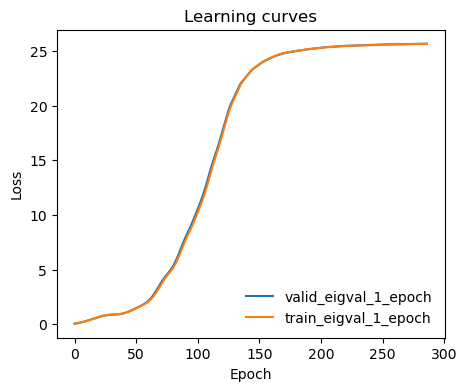

In [7]:
from mlcolvar.utils.plot import plot_metrics

ax = plot_metrics(metrics.metrics, 
                  keys=[x for x in  metrics.metrics.keys() if 'eigval' in x and 'epoch' in x],#['train_loss_epoch','valid_loss'],
                  yscale='linear')

#### Analysis of the CV

In [8]:
# evaluate cv on training set and append to dataframe
X = dataset[:]['data']
model.eval()
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

n_components = n_states-1

for i in range(n_components):
    df[f'CV{i}'] = s[:,i] 

As in the previous example, we can evaluate the histogram of the CV on the training set, from which we see how the two states are now discriminated. 

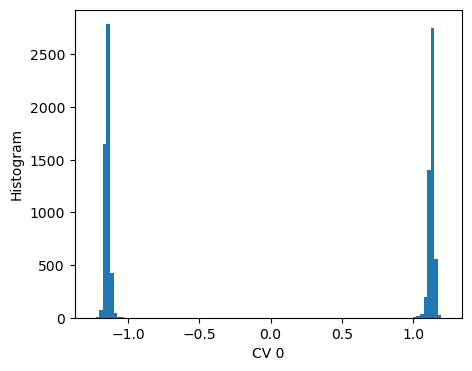

In [9]:
fig,axs = plt.subplots(1,n_components,figsize=(5*n_components,4))
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    ax.hist(s[:,i],bins=100)
    ax.set_xlabel(f'CV {i}')
    ax.set_ylabel('Histogram')

Moreover, we can also visualize the CVs values on a physical space, e.g. in the Ramachandran plot ($\phi$ and $\psi$ space).

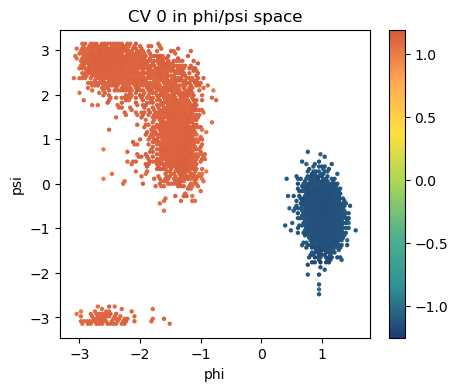

In [10]:
n_components = n_states-1

fig,axs = plt.subplots(1,n_components,figsize=(5*n_components,4))
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    df.plot.hexbin('phi','psi',C=f'CV{i}',cmap='fessa',ax=ax)
    ax.set_title(f'CV {i} in phi/psi space')

By performing an enhanced sampling simulation along the CV we can we can compute the free energy profile and compare the isolines in the whole Ramachandran plot, which show how the DeepLDA CV captures approximately the minimum free energy pathway connecting the two states.

<center><img src="images/ala2-deeplda.png" width="500" /></center>

## Aldol reaction

In this second example we consider the second example reported in the paper, which is an intermolecular aldol reaction between vinyl alcohol and formaldehyde.

We download the data from the [DeepLDA repository](https://github.com/luigibonati/data-driven-CVs/) associated to the [PLUMED-NEST](https://www.plumed-nest.org/eggs/20/004/) submission, which contains unbiased simulations of the reactants and products.

<center><img src="images/aldol-R.jpg" width="500" /><img src="images/aldol-P.jpg" width="500" /></center>

### Load data

In [11]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

filenames = [ "https://raw.githubusercontent.com/luigibonati/data-driven-CVs/master/aldol/1_unbiased/INPUTS.R", 
              "https://raw.githubusercontent.com/luigibonati/data-driven-CVs/master/aldol/1_unbiased/INPUTS.P" ]

n_states = len(filenames)

# load dataset
dataset, df = create_dataset_from_files(filenames,
                                        filter_args={'regex':'cc|oo|co|ch|oh' }, # select contacts 
                                        create_labels=True,
                                        return_dataframe=True, 
                                        )

datamodule = DictModule(dataset,lengths=[0.8,0.2])

Class 0 dataframe shape:  (5001, 43)
Class 1 dataframe shape:  (5001, 43)

 - Loaded dataframe (10002, 43): ['time', 'cc2.0', 'cc2.1', 'cc2.2', 'oo2.0', 'co2.0', 'co2.1', 'co2.2', 'co2.3', 'co2.4', 'co2.5', 'ch2.0', 'ch2.1', 'ch2.2', 'ch2.3', 'ch2.4', 'ch2.5', 'ch2.6', 'ch2.7', 'ch2.8', 'ch2.9', 'ch2.10', 'ch2.11', 'ch2.12', 'ch2.13', 'ch2.14', 'ch2.15', 'ch2.16', 'ch2.17', 'oh2.0', 'oh2.1', 'oh2.2', 'oh2.3', 'oh2.4', 'oh2.5', 'oh2.6', 'oh2.7', 'oh2.8', 'oh2.9', 'oh2.10', 'oh2.11', 'walker', 'labels']
 - Descriptors (10002, 40): ['cc2.0', 'cc2.1', 'cc2.2', 'oo2.0', 'co2.0', 'co2.1', 'co2.2', 'co2.3', 'co2.4', 'co2.5', 'ch2.0', 'ch2.1', 'ch2.2', 'ch2.3', 'ch2.4', 'ch2.5', 'ch2.6', 'ch2.7', 'ch2.8', 'ch2.9', 'ch2.10', 'ch2.11', 'ch2.12', 'ch2.13', 'ch2.14', 'ch2.15', 'ch2.16', 'ch2.17', 'oh2.0', 'oh2.1', 'oh2.2', 'oh2.3', 'oh2.4', 'oh2.5', 'oh2.6', 'oh2.7', 'oh2.8', 'oh2.9', 'oh2.10', 'oh2.11']


### Train DeepLDA CV

In [12]:
from mlcolvar.cvs import DeepLDA

n_input           = dataset['data'].shape[-1]
nodes             = [n_input,30,30,5]
nn_args           = {'activation': 'shifted_softplus'}
options           = {'nn': nn_args}
# MODEL
model = DeepLDA(nodes, n_states=n_states, options=options)

model

DeepLDA(
  (loss_fn): ReduceEigenvaluesLoss()
  (norm_in): Normalization(in_features=40, out_features=40, mode=mean_std)
  (nn): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=40, out_features=30, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=30, out_features=30, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=30, out_features=5, bias=True)
    )
  )
  (lda): LDA(in_features=5, out_features=1)
)

In [13]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=0.1, patience=50)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(

  | Name    | Type                  | Params | In sizes | Out sizes
-------------------------------------------------------------------------
0 | loss_fn | ReduceEigenvaluesLoss | 0      | ?        | ?        
1 | norm_in | Normalization         | 0      | [40]     | [40]     
2 | nn      | FeedForward           | 2.3 K  | [40]     | [5]      
3 | lda     | LDA                   | 0      | [5]      | [1]      
-------------------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     T

/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 538: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s, v_num=44] 


Monitor learning curves

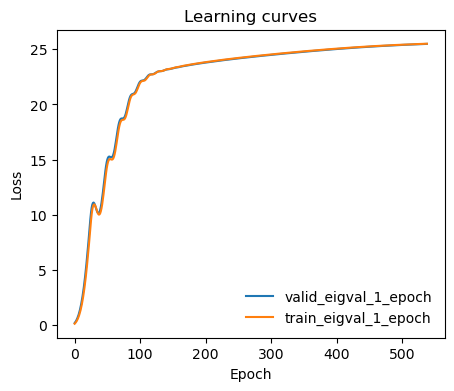

In [14]:
from mlcolvar.utils.plot import plot_metrics

ax = plot_metrics(metrics.metrics, 
                  keys=[x for x in  metrics.metrics.keys() if 'eigval' in x and 'epoch' in x],#['train_loss_epoch','valid_loss'],
                  yscale='linear')

#### Analysis of the CV

In [15]:
# evaluate cv on training set and append to dataframe
X = dataset[:]['data']
model.eval()
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

n_components = n_states-1

for i in range(n_components):
    df[f'CV{i}'] = s[:,i] 

We can evaluate the histogram of the CV on the training set, from which we see how the two states are well discriminated. 

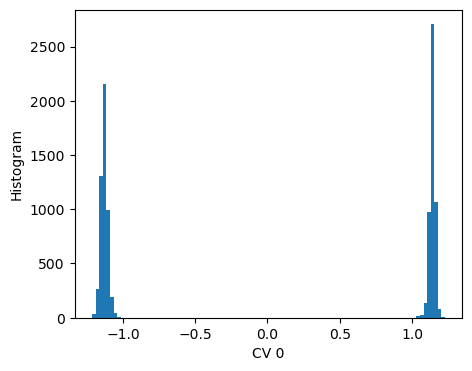

In [16]:
fig,axs = plt.subplots(1,n_components,figsize=(5*n_components,4))
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    ax.hist(s[:,i],bins=100)
    ax.set_xlabel(f'CV {i}')
    ax.set_ylabel('Histogram')

#### Features ranking

We can compute the feature importances by performing a sensitivity analysis, which amounts as measuring how sensitive is the CV $s$ to changes in the input features $x_i$, over a dataset $\{\mathbf{x}^{(j)}\}_{j=1} ^N$:

$$s_i = \frac{1}{N} \sum_j \left|{\frac{\partial s}{\partial x_i}(\mathbf{x}^{(j)})}\right| \sigma_i$$

where $\sigma_i$ is the standard deviation, which is needed if the dataset is not standardized.

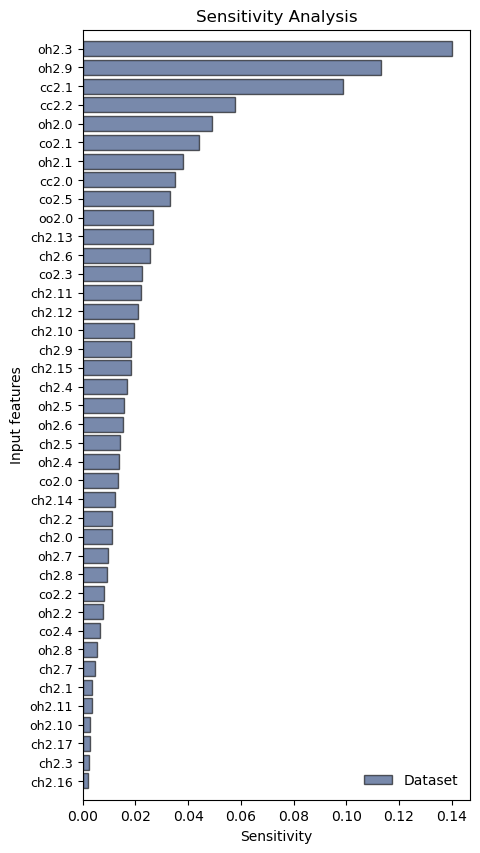

In [17]:
from mlcolvar.utils.explain import sensitivity_analysis

results = sensitivity_analysis(model, dataset, feature_names=dataset.feature_names, per_class=False, plot_mode='barh')

This allows us to identify three dominant features. Indeed, if we plot their distributions, we find that these features undergo significant changes when going from the reactant to the product states

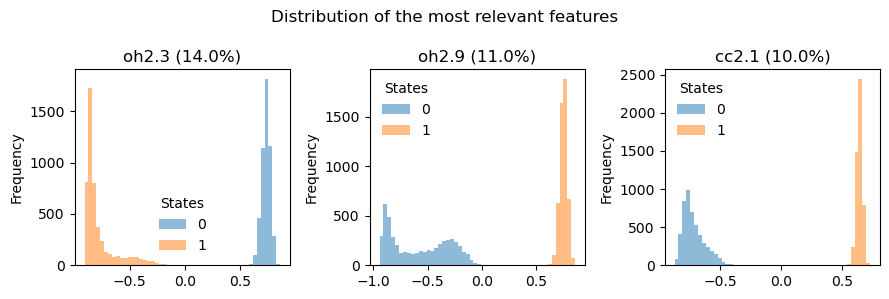

In [18]:
plot_n_features = 3

names = results['feature_names'][-plot_n_features:]
sensitivity = results['sensitivity']['Dataset'][-plot_n_features:]

fig, axs = plt.subplots(1,plot_n_features,figsize=(3*plot_n_features,3))
plt.suptitle('Distribution of the most relevant features')

for ax,name,sensitivity in zip(axs.flatten()[::-1],names,sensitivity):
    df.pivot(columns='labels')[name].plot.hist(bins=50,alpha=0.5,ax=ax)
    ax.set_title(f'{name} ({np.round(sensitivity*100)}%)')
    ax.legend(title='States',frameon=False)

plt.tight_layout()